In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EllipticEnvelope

In [2]:
labeled_data = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/train.csv')
unlabeled_data = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/oob.csv')

# OneClassSVM

# OneClassSVM 특징
- 출처 : [Scikit learn Documentation](https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection)
    
- OneClassSVM은 이상치에 민감하기 때문에 이상탐지에 적절하지는 않음
- 고차원에 대한 이상탐지와 데이터 분포에 대한 가정이 알려져 있지 않는다면 매우 어려운 작업이 될 수 있음
- 그럼에도 OneClassSVM은 이상탐지에 활용이 될 수 있지만 과적합과 이상치를 적절히 탐지하기 위해서는 하이퍼파라미터 nu에 대한 튜닝이 필요
- 커널을 사용하는 OneClassSVM은 그 복잡성이 샘플수에 대해 제곱(Quadratic)꼴로 증가하는 반면, SGDOneClassSVM은 샘플 수에 선형적( linear)으로 증가

In [3]:
from PIL import Image

def img_show(path, ratio=0.7):
    img = Image.open(path)
    w,h = img.size
    img1 = img.resize((int(w*ratio), int(h*ratio)))
    return img1

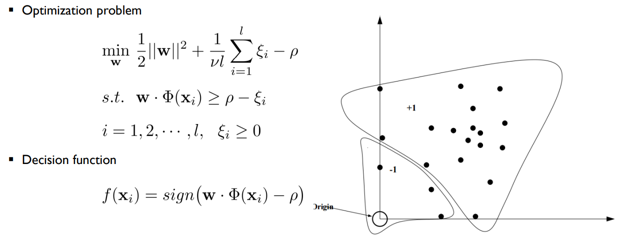

In [4]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/onesvm_1.png', ratio=0.5)

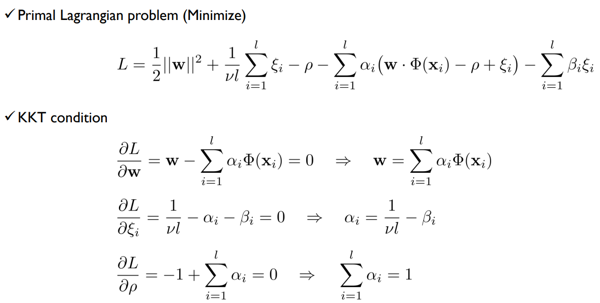

In [5]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/onesvm_2.png', ratio=0.5)

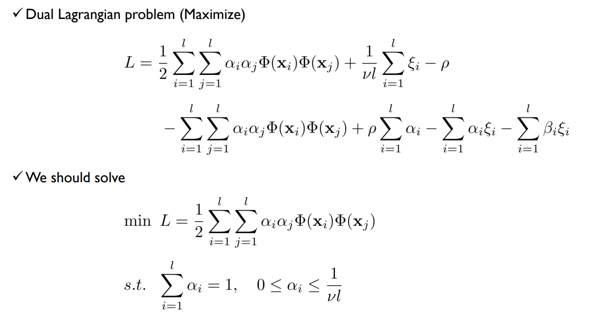

In [6]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/onesvm_3.png', ratio=0.5)

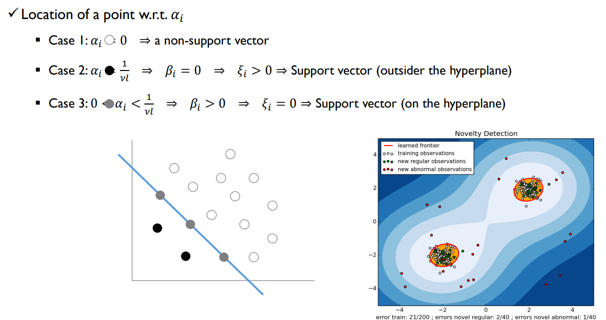

In [7]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/onesvm_4.png', ratio=0.5)

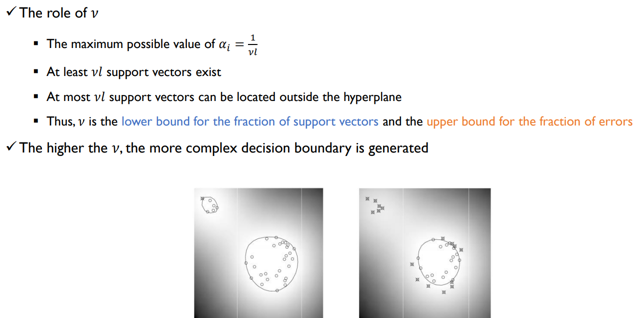

In [8]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/onesvm_5.png', ratio=0.5)

## OneClassSVM 예시

In [9]:
trainX = labeled_data.iloc[:, :-1]
trainY = labeled_data.iloc[:, -1]

In [10]:
trainX['time'] = pd.to_datetime(trainX['date'].astype(str) + trainX['hour'].astype(str), format='%Y%m%d%H')

In [11]:
trainX.fillna(method='ffill', inplace=True)

## 상태 변수 변환(rolling=24h)
출처 : [기간이동 계산 (rolling)](https://wikidocs.net/152788)
- 직전 24시간 평균치로 상태변수로 변환
- rolling 파라미터
    
    - `window` : 계산할 창(window)의 크기, 열 기준으로 계산할 경우 행의 수, 여기서는 24로 설정
    
    - `center` : {True / False} 레이블을 window의 중간에 둘지 여부입니다. 기본값은 False로 레이블이 창 우측에 위치합니다. 현재는 False로 지정(오른쪽)

    - `win_type` : {'triang' / 'gaussian' / ...} 가중치를 넣어 계산할 경우 계산 방식, 연산 메서드에 추가 인수를 지정해야할 수도 있음
        - 가중치 연산에 대한 정보 : [Window functions](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)
        - <font color=yellow>필요하다면 지수이동평균 / 가중이동평균 산식을 적용해서 조금 더 가까운 시간의 정보를 반영하는 평균으로 변환</font>

    - `on` : 시계열 인덱스나, 시계열과 유사한 열이 있을 경우 이 열을 기준으로 rolling을 수행
    - `axis` : 계산의 기준이 될 축, 여기서는 `axis=1`
    - `closed` : {'left' / 'right' / 'both' / 'neither'} window가 닫히는 방향, 여기서는 기본값 right 지정

In [12]:
trainX.columns

Index(['ckey', 'machine_id', 'date', 'hour', 'connect_avg', 'connect_max',
       'in_handover_rate', 'out_handover_rate', 'inter_handover_rate',
       'lower_prb', 'upper_prb', 'reconfig_rate', 'time'],
      dtype='object')

In [13]:
target_columns = ['connect_avg', 'connect_max',
                  'in_handover_rate', 'out_handover_rate', 'inter_handover_rate',
                  'lower_prb', 'upper_prb', 'reconfig_rate']

In [14]:
sma_data = pd.DataFrame()
for i in range(3):
    tmp = trainX.iloc[i*1464:(i+1)*1464, 4:][target_columns].rolling(24).mean()
    sma_data = pd.concat([sma_data, tmp])

In [15]:
sma_data = sma_data.fillna(method='bfill')

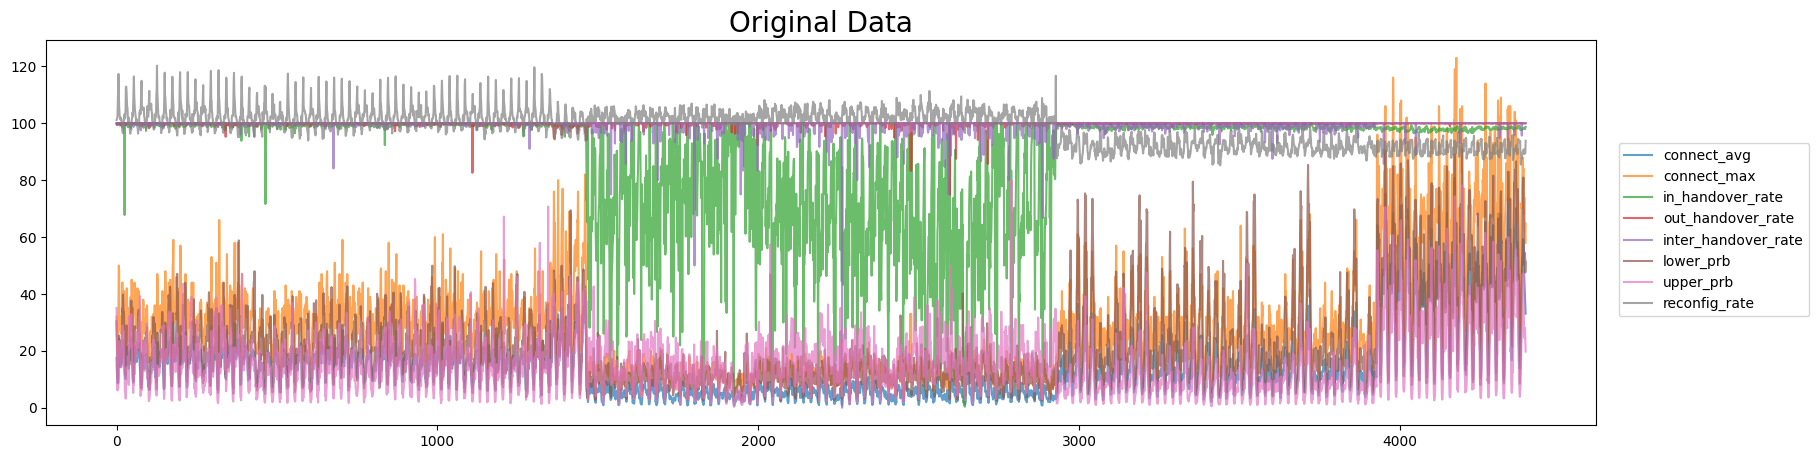

In [16]:
trainX[target_columns].plot(kind='line', figsize=(20, 5), alpha=0.7)
plt.title('Original Data', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
plt.show()

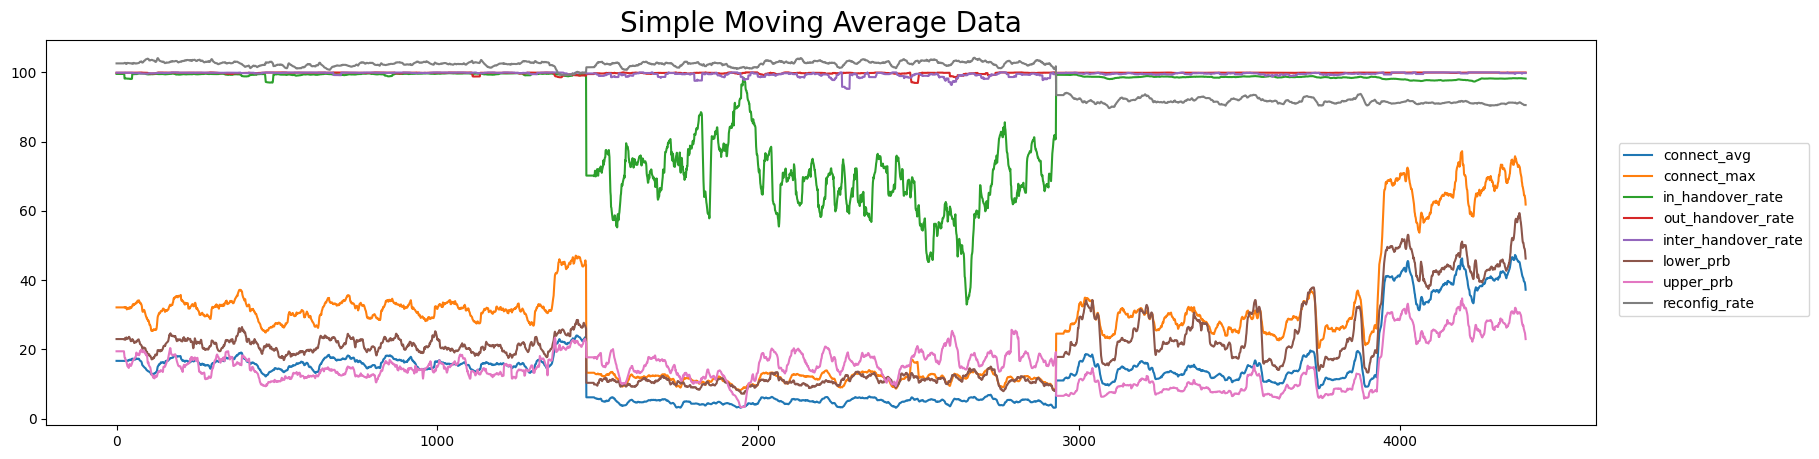

In [17]:
sma_data.plot(kind='line', figsize=(20, 5))
plt.title('Simple Moving Average Data', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
plt.show()

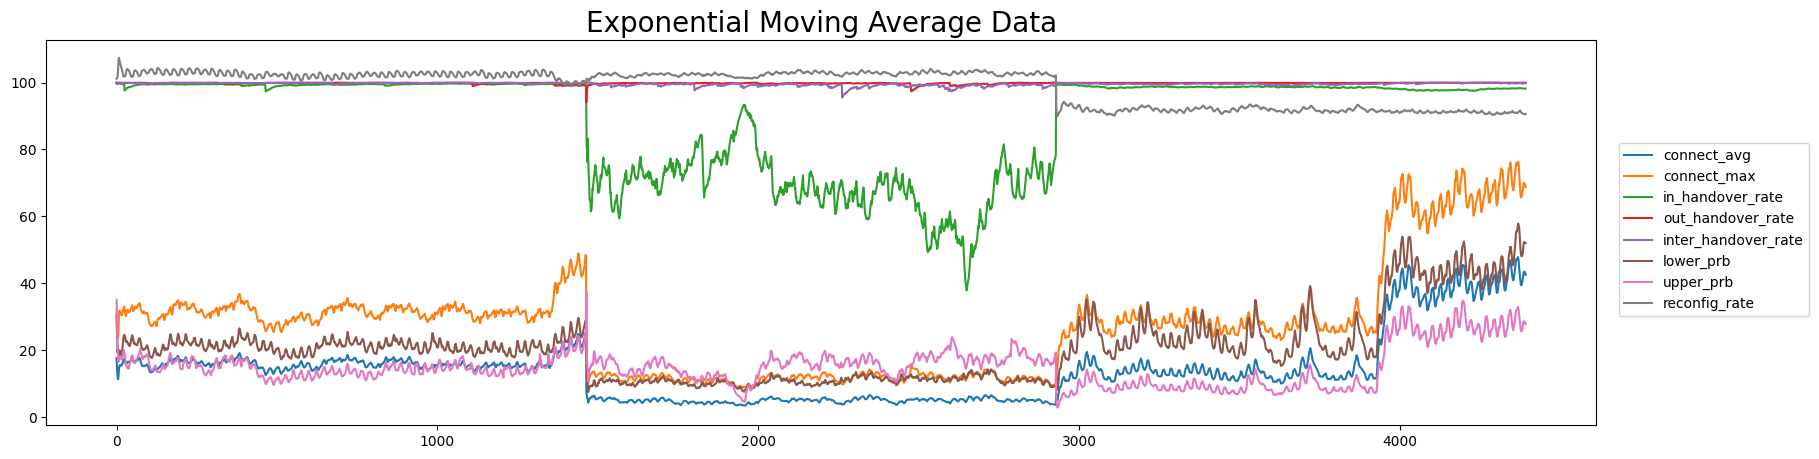

In [18]:
ema_data = pd.DataFrame()
for i in range(3):
    tmp = trainX.iloc[i*1464:(i+1)*1464, 4:][target_columns].ewm(24).mean()
    ema_data = pd.concat([ema_data, tmp])

ema_data = ema_data.fillna(method='bfill')

ema_data.plot(kind='line', figsize=(20, 5))
plt.title('Exponential Moving Average Data', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
plt.show()

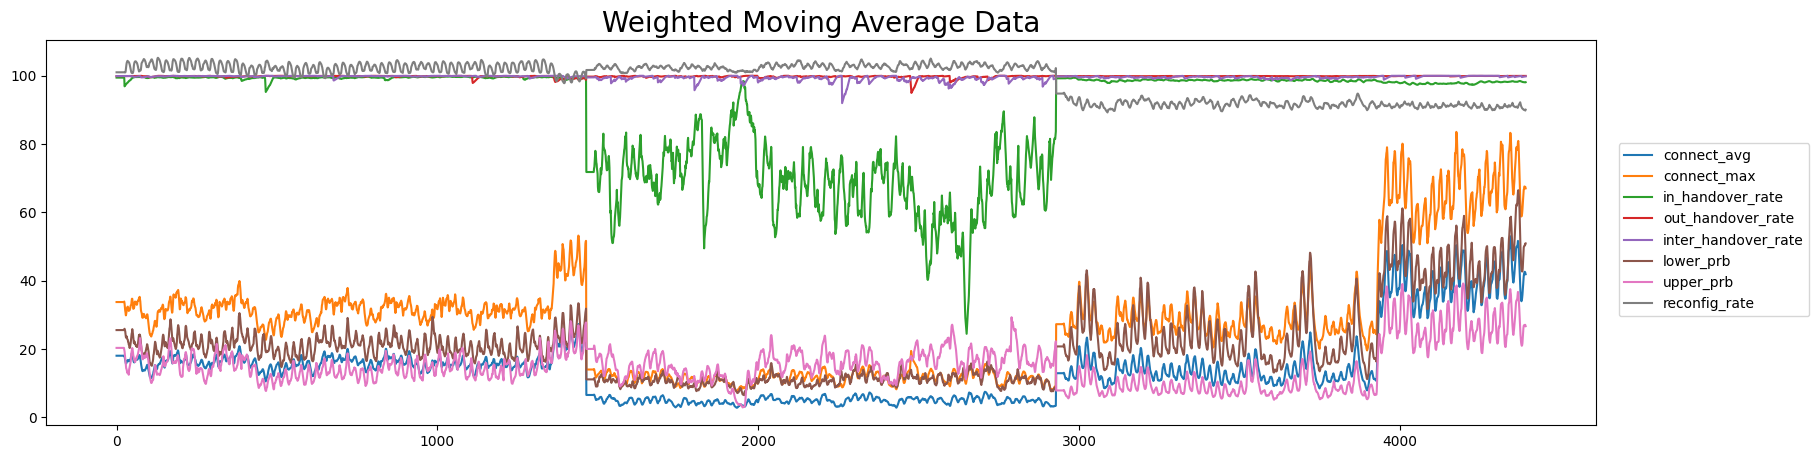

In [19]:
def weighted_mean(weight_array):
    def inner(x):
        return (weight_array * x).mean()
    return inner

weights = np.arange(1,25)
wma_data = pd.DataFrame()
for i in range(3):
    tmp = trainX.iloc[i*1464:(i+1)*1464, 4:][target_columns].rolling(24).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
    wma_data = pd.concat([wma_data, tmp])

wma_data = wma_data.fillna(method='bfill')

wma_data.plot(kind='line', figsize=(20, 5))
plt.title('Weighted Moving Average Data', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
plt.show()

In [20]:
sma_data.sample()

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate
3884,13.057454,27.041667,98.561609,99.931207,99.566262,20.330667,7.779152,92.658134


## 스케일링(필수)
- SVM은 feature들의 scale이 hyperplane을 추정하는데 매우 큰 영향을 미치기 떄문에 반드시 Scaling 작업을 진행해야 함

In [21]:
X_train = wma_data.copy()
y_train = trainY.copy()

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## 모델 fit

In [23]:
clf = OneClassSVM()
clf.fit(X_train)

OneClassSVM()

In [24]:
anomaly_score = np.sort(clf.score_samples(X_train))

In [25]:
anomaly_score

array([  4.76976066,   5.24898377,   6.11838601, ..., 740.65899639,
       741.70110649, 748.30230714])

- Isolation Forest와 다르게 anomaly score가 정규화되어 있지 않음

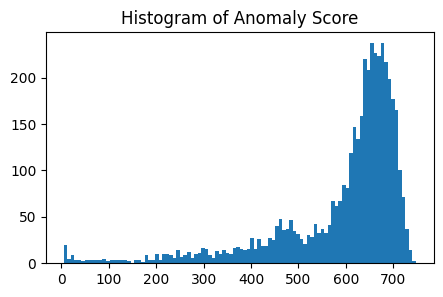

In [26]:
plt.figure(figsize=(5,3))
plt.hist(anomaly_score, bins=100)
plt.title("Histogram of Anomaly Score")
# sns.kdeplot(anomaly_score)
plt.show()

In [27]:
train_pred = np.where(clf.predict(X_train)==1, 0, 1)

In [28]:
print('Isolation Accuracy score :', accuracy_score(y_train, train_pred).round(4))
print('Isolation F1 score :', f1_score(y_train, train_pred).round(4))

Isolation Accuracy score : 0.5314
Isolation F1 score : 0.2613


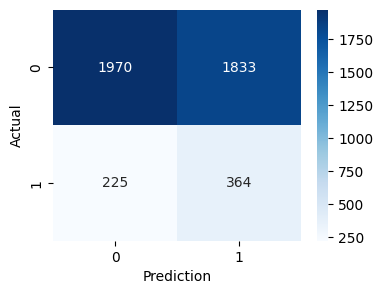

In [29]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_train, train_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

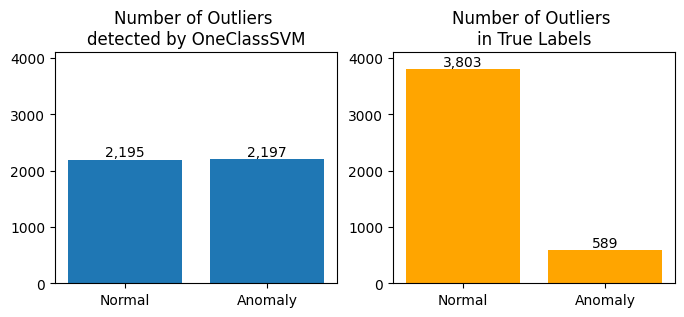

In [30]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

label, count = np.unique(train_pred, return_counts=True)

axs[0].set_title('Number of Outliers \ndetected by OneClassSVM')
bar_container = axs[0].bar(label, count)
axs[0].bar_label(bar_container, fmt='{:,.0f}')
axs[0].set_ylim((0,4100))
axs[0].set_xticks(ticks=label, labels=['Normal', 'Anomaly'])

label, count = np.unique(trainY, return_counts=True)

axs[1].set_title('Number of Outliers \nin True Labels')
bar_container = axs[1].bar(label, count, color='orange')
axs[1].bar_label(bar_container, fmt='{:,.0f}')
axs[1].set_ylim((0,4100))
axs[1].set_xticks(ticks=[0,1], labels=['Normal', 'Anomaly'])
plt.show()

### 하이퍼파라미터 nu
- Isolation Forest와 달리 하이퍼파라미터 nu를 통해 전체 샘플 중 anomaly로 분류하고 싶은 비율을 지정할 수 있음, 기본값은 0.5
- soft margin과 hard margin의 차이와 유사하게 허용 수준이라고 볼 수 있음
- 실제 정답 class label의 정상, 비정상 비율이 0.13이므로 nu를 0.13으로 지정해서 확인

In [31]:
clf = OneClassSVM(nu=0.13)
clf.fit(X_train)

OneClassSVM(nu=0.13)

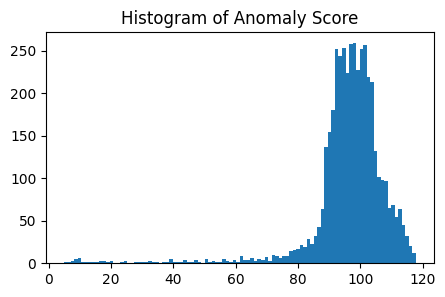

In [32]:
anomaly_score = np.sort(clf.score_samples(X_train))
plt.figure(figsize=(5,3))
plt.hist(anomaly_score, bins=100)
plt.title("Histogram of Anomaly Score")
# sns.kdeplot(anomaly_score)
plt.show()

In [33]:
train_pred = np.where(clf.predict(X_train)==1, 0, 1)

In [34]:
print('OneClassSVM Accuracy score :', accuracy_score(y_train, train_pred).round(4))
print('OneClassSVM F1 score :', f1_score(y_train, train_pred).round(4))

OneClassSVM Accuracy score : 0.7935
OneClassSVM F1 score : 0.2188


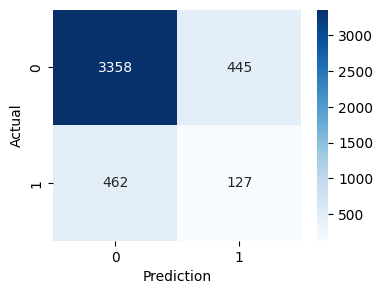

In [35]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_train, train_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

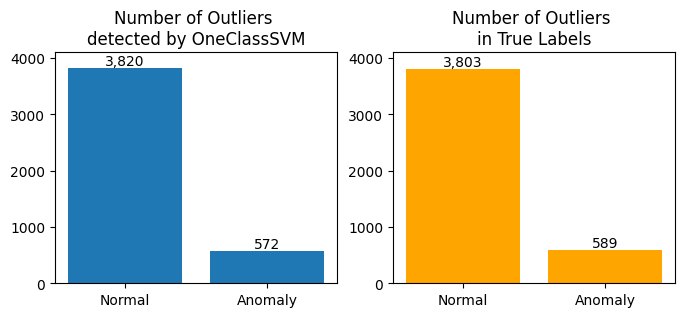

In [36]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

label, count = np.unique(train_pred, return_counts=True)

axs[0].set_title('Number of Outliers \ndetected by OneClassSVM')
bar_container = axs[0].bar(label, count)
axs[0].bar_label(bar_container, fmt='{:,.0f}')
axs[0].set_ylim((0,4100))
axs[0].set_xticks(ticks=label, labels=['Normal', 'Anomaly'])

label, count = np.unique(trainY, return_counts=True)

axs[1].set_title('Number of Outliers \nin True Labels')
bar_container = axs[1].bar(label, count, color='orange')
axs[1].bar_label(bar_container, fmt='{:,.0f}')
axs[1].set_ylim((0,4100))
axs[1].set_xticks(ticks=[0,1], labels=['Normal', 'Anomaly'])
plt.show()

In [37]:
clf = OneClassSVM(nu=0.13)
train_pred = np.zeros(X_train.shape[0])

for i in range(3):
    tmp = X_train[i*1464:(i+1)*1464, :]
    clf.fit(tmp)
    train_pred[i*1464:(i+1)*1464] = np.where(clf.predict(tmp)==1, 0, 1)

print('OneClassSVM Accuracy score :', accuracy_score(y_train, train_pred).round(4))
print('OneClassSVM F1 score :', f1_score(y_train, train_pred).round(4))

OneClassSVM Accuracy score : 0.7782
OneClassSVM F1 score : 0.1603


## 결과 시각화

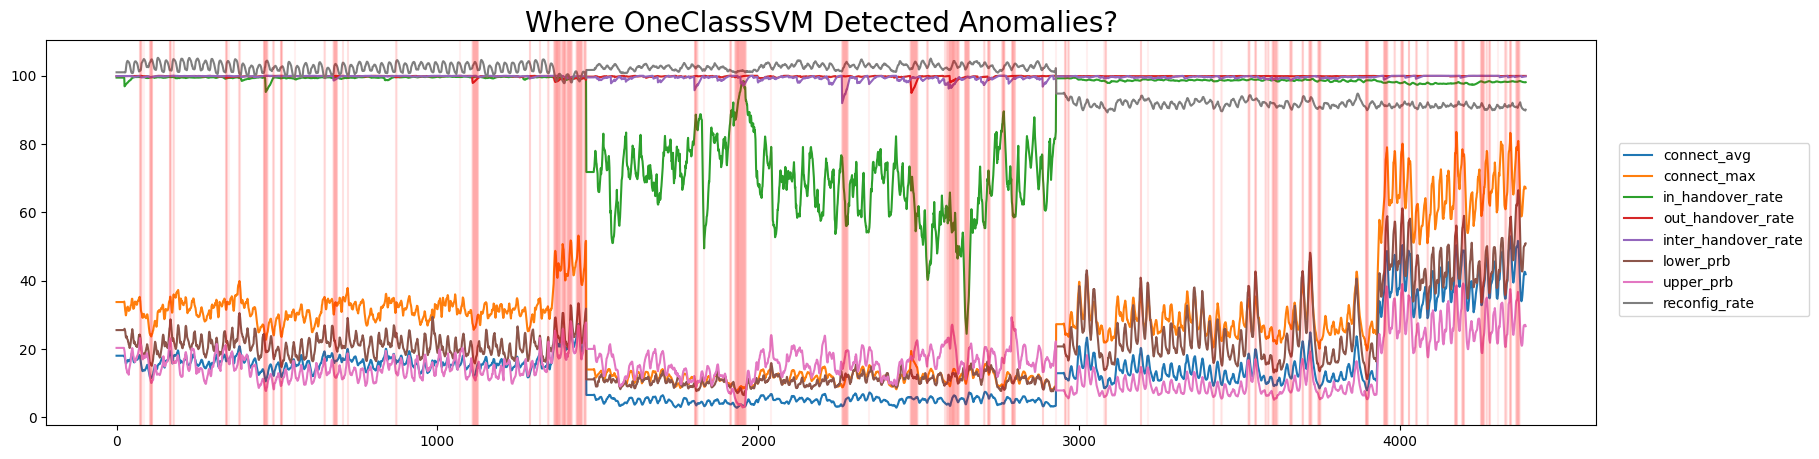

In [38]:
wma_data.plot(kind='line', figsize=(20, 5))
plt.title('Where OneClassSVM Detected Anomalies?', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
for idx in np.argwhere(train_pred == 1):
    plt.axvline(x=idx, color='r', linestyle='-', alpha=0.06)
plt.show()

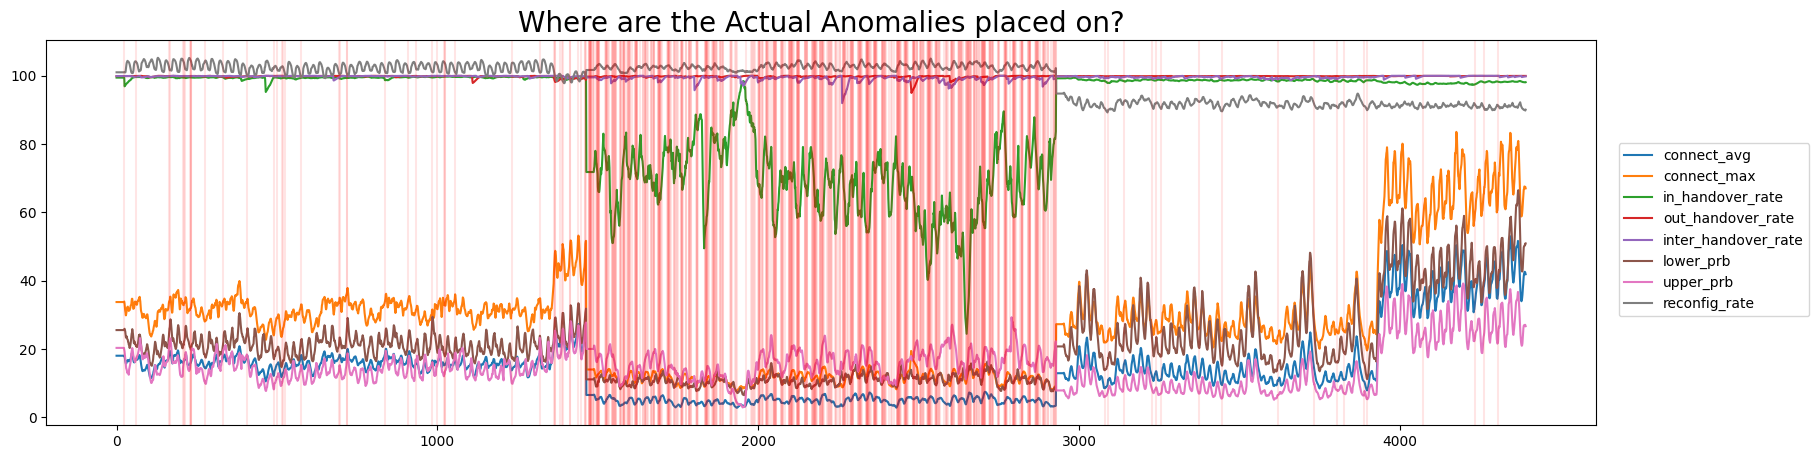

In [39]:
wma_data.plot(kind='line', figsize=(20, 5))
plt.title('Where are the Actual Anomalies placed on?', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
for idx in np.argwhere(y_train.values == 1):
    plt.axvline(x=idx, color='r', linestyle='-', alpha=0.1)
plt.show()

In [40]:
def find_anomalies_machine(df:str, machine_id:str, target_columns=target_columns):
    tmp = df.loc[df.machine_id == machine_id][target_columns].rolling(24).mean()
    tmp.fillna(method='bfill', inplace = True)
    tmp.reset_index(drop=True, inplace = True)
    # display(tmp)
    clf = OneClassSVM(nu=0.13)
    clf.fit(tmp)

    train_pred = np.where(clf.predict(tmp)==1, 0, 1)

    tmp.plot(kind='line', figsize=(18, 3))
    plt.title(f'Point of Anomalies in {machine_id}', fontsize=20)
    plt.legend(bbox_to_anchor=(1.01,0.75))
    for idx in np.argwhere(train_pred == 1):
        plt.axvline(x=idx, color='r', linestyle='-', alpha=0.1)
    plt.show()

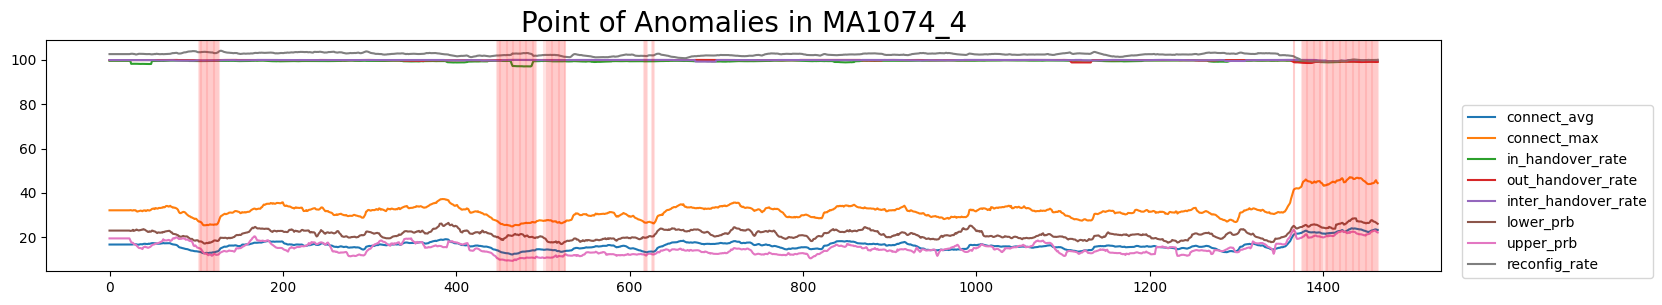

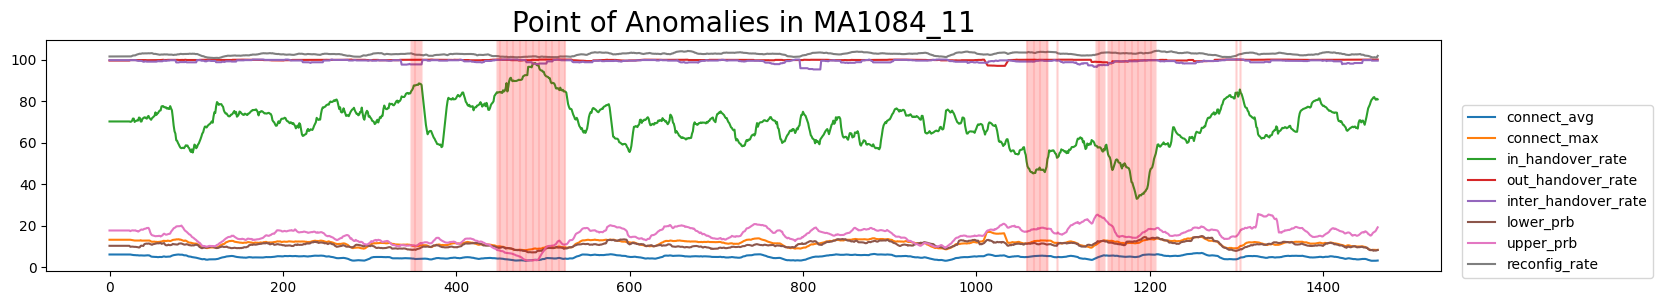

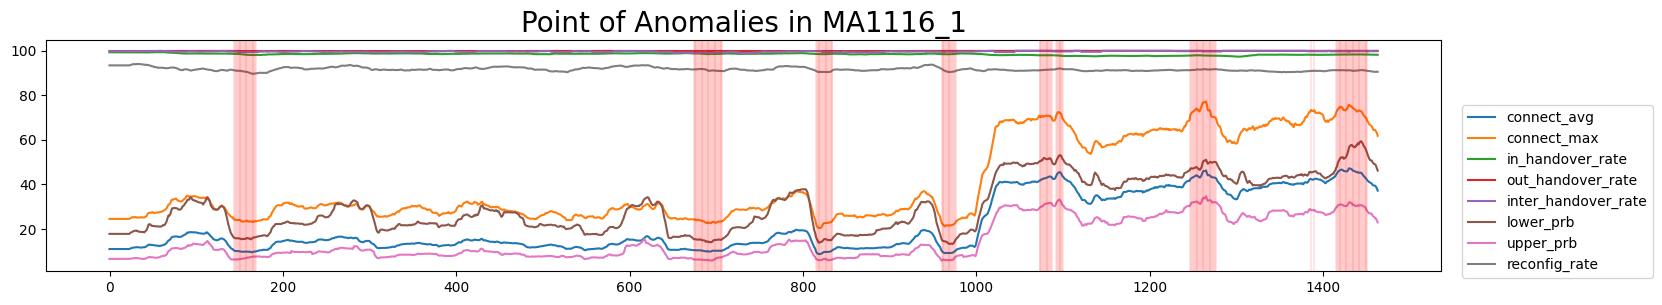

In [41]:
for machine_id in list(trainX.machine_id.unique()):
    find_anomalies_machine(df=trainX, machine_id = machine_id)

## OOB 테스트

In [42]:
oob = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/oob.csv')

In [43]:
oob.head()

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate
0,MA1004_0-20210901-0,MA1004_0,20210901,0,27.913285,43.0,97.523220,100.000000,100.0,45.402603,59.021408,100.409763
1,MA1004_0-20210901-1,MA1004_0,20210901,1,23.013333,36.0,98.170732,NaN,100.0,36.740540,21.128778,99.953052
2,MA1004_0-20210901-2,MA1004_0,20210901,2,22.158977,38.0,98.039216,98.765432,100.0,28.568421,15.338933,100.249377
3,MA1004_0-20210901-3,MA1004_0,20210901,3,18.396667,34.0,98.717949,100.000000,100.0,16.503713,8.009815,100.512821
4,MA1004_0-20210901-4,MA1004_0,20210901,4,14.173889,28.0,97.014925,100.000000,100.0,14.133542,5.109716,99.923136


In [44]:
oob['time'] = pd.to_datetime(oob['date'].astype(str) + oob['hour'].astype(str), format='%Y%m%d%H')

In [45]:
oob.fillna(method='ffill', inplace=True)

In [46]:
for machine_id in list(oob.machine_id.unique()):
    find_anomalies_machine(df=oob, machine_id = machine_id)

Output hidden; open in https://colab.research.google.com to view.

## 커널함수 변경

In [47]:
kernel_list = ['rbf', 'linear', 'sigmoid', 'poly']

In [48]:
for kernel in kernel_list:
    clf = OneClassSVM(nu=0.13, kernel=kernel)
    clf.fit(X_train)

    train_pred = np.where(clf.predict(X_train)==1, 0, 1)

    print(f'{kernel} OCSVM Accuracy score :', accuracy_score(y_train, train_pred).round(4))
    print(f'{kernel} OCSVM F1 score :', f1_score(y_train, train_pred).round(4))
    print(f'{kernel} OCSVM AUC score :', roc_auc_score(y_train, train_pred).round(4))
    print()

rbf OCSVM Accuracy score : 0.7935
rbf OCSVM F1 score : 0.2188
rbf OCSVM AUC score : 0.5493

linear OCSVM Accuracy score : 0.4681
linear OCSVM F1 score : 0.2135
linear OCSVM AUC score : 0.4977

sigmoid OCSVM Accuracy score : 0.7691
sigmoid OCSVM F1 score : 0.1259
sigmoid OCSVM AUC score : 0.4965

poly OCSVM Accuracy score : 0.7541
poly OCSVM F1 score : 0.0894
poly OCSVM AUC score : 0.4735



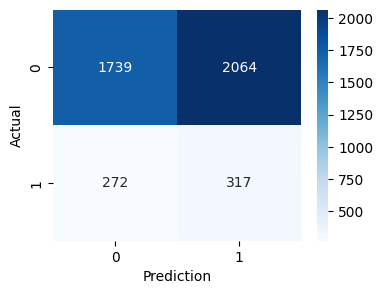

In [49]:
clf = OneClassSVM(nu=0.13, kernel='linear')
clf.fit(X_train)

train_pred = np.where(clf.predict(X_train)==1, 0, 1)

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_train, train_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [50]:
for i in range(3):
    actual = y_train[i*1464:(i+1)*1464]
    predicted = train_pred[i*1464:(i+1)*1464]
    print(f'{i+1}\'s machine OCSVM Accuracy score :', accuracy_score(actual, predicted).round(4))
    print(f'{i+1}\'s machine OCSVM F1 score :', f1_score(actual, predicted).round(4))
    print(f'{i+1}\'s machine OCSVM AUC score :', roc_auc_score(actual, predicted).round(4))
    print()

1's machine OCSVM Accuracy score : 0.679
1's machine OCSVM F1 score : 0.0167
1's machine OCSVM AUC score : 0.3912

2's machine OCSVM Accuracy score : 0.4754
2's machine OCSVM F1 score : 0.4361
2's machine OCSVM AUC score : 0.4959

3's machine OCSVM Accuracy score : 0.25
3's machine OCSVM F1 score : 0.0283
3's machine OCSVM AUC score : 0.5655



In [51]:
path = '/content/drive/MyDrive/ASAC3기_이상탐지/Data/Machine_Signal_Sample3_Y.csv'

answer = pd.read_csv(path)
answer

,ckey,machine_id,date,hour,Y
0,MA1074_4-20210901-22,MA1074_4,20210901,22,1
1,MA1074_4-20210903-12,MA1074_4,20210903,12,1
2,MA1074_4-20210907-18,MA1074_4,20210907,18,1
3,MA1074_4-20210907-23,MA1074_4,20210907,23,1
4,MA1074_4-20210909-16,MA1074_4,20210909,16,1
...,...,...,...,...,...
584,MA1116_1-20211011-8,MA1116_1,20211011,8,1
585,MA1116_1-20211018-16,MA1116_1,20211018,16,1
586,MA1116_1-20211025-8,MA1116_1,20211025,8,1
587,MA1116_1-20211026-13,MA1116_1,20211026,13,1


In [52]:
answer.groupby(['machine_id', 'Y']).count()

,,ckey,date,hour
machine_id,Y,,,
MA1074_4,1,48,48,48
MA1084_11,1,523,523,523
MA1116_1,1,18,18,18
